In [1]:
!pip install numpy
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 6.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink-

In [2]:
!wandb login de83b34df4865f6d73caa690771345a92e44bb2d

wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [3]:
!git clone https://github.com/OscarOvanger/GeoDecepticon.git

Cloning into 'GeoDecepticon'...
remote: Enumerating objects: 20088, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 20088 (delta 194), reused 131 (delta 129), pack-reused 19846 (from 3)
Receiving objects: 100% (20088/20088), 129.94 MiB | 26.62 MiB/s, done.
Resolving deltas: 100% (472/472), done.
Updating files: 100% (80/80), done.


In [4]:
import os
os.chdir('/content/GeoDecepticon')

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import wandb
import os
from tqdm.notebook import tqdm
import copy
from GeneralViT import VisionTransformer, create_model
from tqdm import tqdm  # For progress bars
from Claude_ViT import *
import time

# Load and plot training data

(9000, 64, 64)


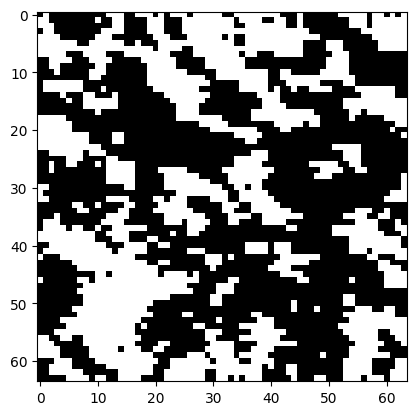

In [6]:
arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
training_data = arr[:9000]
test_data = arr[9000:]
# We reshape it to 60x60 dataset
training_data = training_data.reshape(-1, 64, 64)
test_data = test_data.reshape(-1, 64, 64)
print(training_data.shape)
training_data = torch.tensor(training_data,dtype=torch.float32)
sanity_check_data = training_data[:10]
test_data = torch.tensor(test_data,dtype=torch.float32)
#plot the first data
plt.imshow(training_data[0],cmap='gray')
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars
import matplotlib.patches as mpatches  # For drawing colored borders
import math

########################################
# Build Vocabulary and Mask Token
########################################

def build_vocabulary(training_data, patch_size, cap_size):
    """
    Scans all non-overlapping patches in training_data and builds a vocabulary of unique patches.

    Args:
        training_data (torch.Tensor or numpy.array): Tensor of shape (N, H, W).
        patch_size (int): Size of the patch (e.g., 8 for an 8x8 patch).

    Returns:
        vocab (torch.Tensor): Unique patches, shape (num_unique, patch_size*patch_size).
        counts (torch.Tensor): Count for each unique patch, shape (num_unique,).
        mask_token (torch.Tensor): Mask token, a tensor of shape (patch_size*patch_size,) with all values 0.5.
    """
    if not isinstance(training_data, torch.Tensor):
        training_data = torch.tensor(training_data, dtype=torch.float32)

    N, H, W = training_data.shape

    # Extract non-overlapping patches using unfold.
    patches = training_data.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    patches = patches.contiguous().view(N, -1, patch_size * patch_size)
    patches_flat = patches.view(-1, patch_size * patch_size)

    # Find unique patches and their counts.
    vocab, counts = torch.unique(patches_flat, dim=0, return_counts=True)
    sorted_indices = torch.argsort(counts, descending=True)
    vocab = vocab[sorted_indices][:cap_size]
    counts = counts[sorted_indices][:cap_size]

    # Create a learnable mask token, initialized to 0.5.
    mask_token_torch = torch.full((patch_size * patch_size,), 0.5, dtype=torch.float32)
    mask_token = nn.Parameter(mask_token_torch, requires_grad=True)

    return vocab, counts, mask_token

########################################
# Helper: Convert Patches to Image
########################################

def patches_to_image(patches, img_shape, patch_size):
    """
    Reconstructs an image from patches.

    Args:
        patches (torch.Tensor): Tensor of shape [num_patches, patch_dim].
        img_shape (tuple): (H, W) of the original image.
        patch_size (int): The side length of a square patch.

    Returns:
        image (torch.Tensor): Reconstructed image of shape (H, W).
    """
    H, W = img_shape
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    image = patches.view(num_patches_h, num_patches_w, patch_size, patch_size)
    image = image.permute(0, 2, 1, 3).contiguous().view(H, W)
    return image

########################################
# Transformer Encoder Block and Stacked ViT
########################################

class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_dim, num_heads, ffn_dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=emb_dim, num_heads=num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(emb_dim)
        self.ffn = nn.Sequential(
            nn.Linear(emb_dim, ffn_dim),
            nn.GELU(),
            nn.Linear(ffn_dim, emb_dim)
        )
        self.norm2 = nn.LayerNorm(emb_dim)

    def forward(self, x, attn_mask=None):
        attn_out, _ = self.attn(x, x, x, attn_mask=attn_mask)
        x = self.norm1(x + attn_out)
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        return x

class StackedContextViT(nn.Module):
    def __init__(self, vocab, mask_token, patch_dim, num_patches, emb_dim=128, num_heads=1,
                 num_layers=1, ffn_dim=None):
        super().__init__()
        self.vocab = vocab
        self.vocab_size = vocab.size(0)
        self.patch_dim = patch_dim
        self.emb_dim = emb_dim
        self.mask_token = mask_token
        self.num_patches = num_patches

        self.patch_proj = nn.Linear(patch_dim, emb_dim)
        self.pos_emb = nn.Parameter(torch.zeros(num_patches, emb_dim))
        nn.init.trunc_normal_(self.pos_emb, std=0.02)

        self.rel_bias = nn.Parameter(torch.zeros(num_patches, num_patches))
        nn.init.trunc_normal_(self.rel_bias, std=0.02)

        ffn_dim = ffn_dim if ffn_dim is not None else emb_dim * 4
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderBlock(emb_dim, num_heads, ffn_dim)
            for _ in range(num_layers)
        ])

        self.out_proj = nn.Linear(emb_dim, self.vocab_size)

    def forward(self, patches, mask_rate):
        B, N, P = patches.shape
        mask = torch.rand(B, N, device=patches.device) < mask_rate
        x = patches.clone()
        x[mask] = self.mask_token  # replace masked positions with the mask token

        x = self.patch_proj(x)
        x = x + self.pos_emb.unsqueeze(0)

        attn_mask = self.rel_bias[:N, :N]

        for layer in self.encoder_layers:
            x = layer(x, attn_mask=attn_mask)

        logits = self.out_proj(x)
        return logits, mask

########################################
# Dataset Class and Utility
########################################

class BinaryImageDataset(Dataset):
    def __init__(self, images):
        """
        images: Tensor of shape [N, H, W] (binary images)
        """
        self.images = images

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return self.images[idx]

    @staticmethod
    def batch_to_patches(images, patch_size):
        B, H, W = images.shape
        patches = images.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
        patches = patches.contiguous().view(B, -1, patch_size * patch_size)
        return patches

########################################
# Global Reconstruction Loss
########################################

# Global loss module (L1 loss between the reconstructed image and the ground-truth)
class GlobalReconstructionLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.L1Loss()

    def forward(self, reconstructed_image, ground_truth):
        return self.l1(reconstructed_image, ground_truth)

########################################
# Generates conditional images
########################################

def generate_image(
    model,
    patch_size,
    image_size,
    condition_indices=None,
    condition_values=None,
    generation_order="manhattan"
):
    """
    Generate an image (as a tensor of shape [H, W]) conditionally based on observed cells,
    using different generation orders for unobserved patches.

    Args:
        model: The trained ViT model.
               Assumes model.vocab is a tensor of shape [vocab_size, patch_dim] and
               model.mask_token is a tensor of shape [patch_dim].
        patch_size: The side length of each square patch.
        image_size: The side length of the square image.
        condition_indices: A list (or tensor) of flattened full image indices where cells are observed.
        condition_values: A list (or tensor) of the same length as condition_indices containing
                          the observed cell values (e.g. 0 or 1).
        generation_order: One of {"manhattan", "raster", "random"} controlling how unobserved
                          patches are generated after the observed patches.

    Returns:
        generated_image: A tensor of shape [image_size, image_size] representing the generated image.
        log_likelihood_sum: The sum of the log-likelihoods for each patch sampled.
    """
    # Set model to evaluation mode.
    model.eval()

    # Compute grid dimensions.
    grid_size = image_size // patch_size  # assuming image_size is divisible by patch_size
    total_patches = grid_size * grid_size
    patch_dim = patch_size * patch_size

    # Create an initial "generated" representation: all patches are initially the mask token.
    # Shape: [total_patches, patch_dim]
    generated_patches = model.mask_token.expand(total_patches, patch_dim).clone()

    # Build a mapping from patch index -> list of (local_index, observed value)
    conditions_by_patch = {}
    if condition_indices is not None and condition_values is not None:
        for cond_idx, cond_val in zip(condition_indices, condition_values):
            # Convert the full-image index to (row, col)
            pixel_row = cond_idx // image_size
            pixel_col = cond_idx % image_size
            # Determine which patch this pixel falls into.
            patch_row = pixel_row // patch_size
            patch_col = pixel_col // patch_size
            patch_idx = patch_row * grid_size + patch_col
            # Determine cell (local) coordinates within the patch.
            local_row = pixel_row % patch_size
            local_col = pixel_col % patch_size
            local_idx = local_row * patch_size + local_col
            # Save this condition in the dictionary.
            if patch_idx not in conditions_by_patch:
                conditions_by_patch[patch_idx] = []
            conditions_by_patch[patch_idx].append((local_idx, cond_val))

    # 1) Observed patches first.
    observed_patch_ids = sorted(list(conditions_by_patch.keys()))

    # 2) Unobserved patches, order determined by generation_order.
    unobserved_patch_ids = []
    observed_rows = [(pid // grid_size) for pid in observed_patch_ids]
    observed_cols = [(pid % grid_size) for pid in observed_patch_ids]

    # Gather all unobserved patches:
    all_patch_indices = set(range(total_patches))
    for pid in observed_patch_ids:
        if pid in all_patch_indices:
            all_patch_indices.remove(pid)

    if generation_order == "manhattan":
        # For patches without conditions, compute Manhattan distance sum to all observed patches.
        distance_list = []
        for p in all_patch_indices:
            row = p // grid_size
            col = p % grid_size
            dist_sum = 0
            for op in observed_patch_ids:
                orow = op // grid_size
                ocol = op % grid_size
                dist_sum += abs(row - orow) + abs(col - ocol)
            distance_list.append((p, dist_sum))
        distance_list.sort(key=lambda x: x[1])
        unobserved_patch_ids = [p for p, _ in distance_list]

    elif generation_order == "raster":
        # Sort by patch index in ascending order (row-major).
        unobserved_patch_ids = sorted(list(all_patch_indices))

    elif generation_order == "random":
        import random
        unobserved_patch_ids = list(all_patch_indices)
        random.shuffle(unobserved_patch_ids)

    else:
        raise ValueError(f"Unknown generation_order: {generation_order}. "
                         "Must be one of ['manhattan', 'raster', 'random'].")

    # Combine into a final sampling order: observed first, then the unobserved in the chosen order.
    sampling_order = observed_patch_ids + unobserved_patch_ids

    log_likelihood_sum = 0.0

    # Now, generate patch-by-patch.
    # We use a batch size of 1 for generation.
    for p_idx in sampling_order:
        current_tokens = generated_patches.unsqueeze(0).clone()  # [1, total_patches, patch_dim]
        # During generation we do not want additional random masking, so pass mask_rate=0.
        with torch.no_grad():
            logits, _ = model(current_tokens, mask_rate=0.0)  # logits shape: [1, total_patches, vocab_size]
        logits_current = logits[0, p_idx]  # shape [vocab_size]

        # If this patch has observations, filter logits to keep only vocabulary entries that match.
        if p_idx in conditions_by_patch:
            valid_candidates = torch.ones(model.vocab.shape[0], dtype=torch.bool, device=logits.device)
            for local_idx, cond_val in conditions_by_patch[p_idx]:
                valid_candidates &= (model.vocab[:, local_idx] == cond_val)
            logits_current[~valid_candidates] = -float("inf")

        # Compute probabilities from the logits.
        probs = F.softmax(logits_current, dim=-1)
        # Sample an index from the distribution.
        sampled_idx = torch.multinomial(probs, num_samples=1).item()
        # Accumulate the log probability.
        log_prob = torch.log(probs[sampled_idx] + 1e-10).item()  # add epsilon for stability
        log_likelihood_sum += log_prob

        # Retrieve the sampled patch from the vocabulary.
        sampled_patch = model.vocab[sampled_idx]
        # Update the generated patches.
        generated_patches[p_idx] = sampled_patch

    # Reconstruct the full image from patches.
    generated_image = patches_to_image(generated_patches, (image_size, image_size), patch_size)

    return generated_image, log_likelihood_sum




########################################
# Training Loop with Progress Bar and Updated Plotting
########################################

import wandb  # make sure wandb is installed: pip install wandb
def run_training(training_data, nr_epochs, batch_size, mask_rate, final_mask_rate, mask_schedule, patch_size, num_heads, num_layers, ffn_dim, learning_rate, emb_dim, vocab_cap):
    """
    training_data: numpy array or tensor of shape [N, H, W] (binary images)
    nr_epochs: number of epochs for training
    batch_size: training batch size
    mask_rate: initial masking probability.
    final_mask_rate: final masking probability.
    mask_schedule: one of 'linear', 'exp', or 'log' that defines the growth of mask_rate.
    patch_size: patch size (square); for your experiment use 2 if desired.
    """
    # Initialize wandb
    wandb.init(project="ViT_conditional", config={
        "nr_epochs": nr_epochs,
        "batch_size": batch_size,
        "mask_rate": mask_rate,
        "final_mask_rate": final_mask_rate,
        "mask_schedule": mask_schedule,
        "patch_size": patch_size,
        "num_heads": num_heads,
        "num_layers": num_layers,
        "ffn_dim": ffn_dim,
        "learning_rate": learning_rate,
        "emb_dim": emb_dim
    })

    if not isinstance(training_data, torch.Tensor):
        training_data = torch.tensor(training_data, dtype=torch.float32)

    dataset = BinaryImageDataset(training_data)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    B_total, H_img, W_img = training_data.shape
    num_patches = (H_img // patch_size) * (W_img // patch_size)
    patch_dim = patch_size * patch_size

    # Build vocabulary and mask token.
    vocab, counts, mask_token = build_vocabulary(training_data, patch_size, cap_size=vocab_cap)
    print("vocab size:\n", vocab.size(0))

    # Create the ViT model.
    model = StackedContextViT(vocab, mask_token, patch_dim, num_patches,
                              emb_dim, num_heads, num_layers, ffn_dim)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.vocab = model.vocab.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(nr_epochs):
        # Compute the current masking rate according to the selected schedule.
        if mask_schedule == "linear":
            current_mask_rate = mask_rate + (final_mask_rate - mask_rate) * (epoch / (nr_epochs - 1))
        elif mask_schedule == "exp":
            current_mask_rate = mask_rate * ((final_mask_rate / mask_rate) ** (epoch / (nr_epochs - 1)))
        elif mask_schedule == "log":
            current_mask_rate = mask_rate + (final_mask_rate - mask_rate) * (math.log(epoch + 1) / math.log(nr_epochs))
        else:
            current_mask_rate = mask_rate  # fallback to constant rate

        model.train()
        total_loss = 0.0
        total_correct = 0
        total_masked = 0

        # Variables to store outputs from the last batch for plotting.
        last_batch_images = None
        last_batch_patches = None
        last_batch_mask = None
        last_batch_logits = None
        last_targets = None

        # Progress bar for this epoch.
        for batch in tqdm(loader, desc=f"Epoch {epoch+1}/{nr_epochs}"):
            batch = batch.to(device)
            patches = BinaryImageDataset.batch_to_patches(batch, patch_size)  # shape [B, N, patch_dim]
            B, N, P = patches.shape

            logits, mask = model(patches, current_mask_rate)

            patches_bin = patches.round()
            patches_flat = patches_bin.view(B * N, P)
            dists = torch.cdist(patches_flat, model.vocab)
            targets = torch.argmin(dists, dim=1).view(B, N)

            if mask.sum() > 0:
                loss = criterion(logits[mask], targets[mask])
            else:
                loss = torch.tensor(0.0, device=device)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * mask.sum().item()
            preds = logits.argmax(dim=-1)
            total_correct += (preds[mask] == targets[mask]).sum().item()
            total_masked += mask.sum().item()

            # Save last batch data (including targets) for plotting.
            last_batch_images = batch.detach().cpu()
            last_batch_patches = patches.detach().cpu()
            last_batch_mask = mask.detach().cpu()
            last_batch_logits = logits.detach().cpu()
            last_targets = targets.detach().cpu()

        avg_loss = total_loss / max(1, total_masked)
        acc = total_correct / max(1, total_masked)
        scheduler.step() #Change laber
        # Log epoch metrics.
        wandb.log({
            "epoch": epoch+1,
            "avg_loss": avg_loss,
            "masked_accuracy": acc,
            "mask_rate": current_mask_rate,
            "learning_rate": scheduler.get_last_lr()[0]
        })
        print(f"Epoch {epoch+1}/{nr_epochs} | Loss: {avg_loss:.4f} | Masked Acc: {acc:.4f}")

        if (epoch + 1) % 100 == 0:
          torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")
          print(f"Saved model at epoch {epoch+1}")

        # ---- Every 10 epochs, perform conditional generation and log to wandb ----
        if (epoch+1) % 50 == 0:
            # Sample conditions for generation.
            condition_indices = np.array([876,3825,2122,2892,1556,2683,3667,1767,483,2351,
                                2000,3312,2953,289,2373,2720,872,2713,1206,1341,
                                3541,2226,3423,1904,2882,2540,1497,2524,264,1441])
            condition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,
                                          1,1,1,0,1,0,1,1,0,1])
            generated_img, log_likelihood_sum = generate_image(model, patch_size, W_img, condition_indices=None, condition_values=None) #unconditional for now
            # Create a figure for the generated image.
            fig_gen, ax_gen = plt.subplots(figsize=(12,12))
            # Convert conditions to grid coordinates for plotting.
            condition_indices_x = condition_indices // W_img
            condition_indices_y = condition_indices % W_img
            ax_gen.imshow(generated_img.cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
            ax_gen.scatter(condition_indices_y, condition_indices_x, c=condition_values, cmap='viridis')
            ax_gen.set_title(f"Conditional Generation @ Epoch {epoch+1}\nLL: {log_likelihood_sum:.4f}")
            ax_gen.axis("off")
            wandb.log({"conditional_generation": wandb.Image(fig_gen, caption=f"Epoch {epoch+1}")})
            plt.close(fig_gen)

        # ---- (Optional) Plotting the last batch reconstruction and log to wandb ----
        if (epoch+1) % 10 == 0:
          if last_batch_images is not None:
              last_image = last_batch_images[-1]         # [H_img, W_img]
              last_orig_patches = last_batch_patches[-1]    # [N, patch_dim]
              last_mask = last_batch_mask[-1]               # [N]
              last_logits = last_batch_logits[-1]           # [N, vocab_size]
              last_targets_img = last_targets[-1]           # [N]

              last_pred = last_logits.argmax(dim=-1)

              reconstructed_patches = last_orig_patches.clone()
              pred_patches = model.vocab[last_pred].detach().cpu()
              reconstructed_patches[last_mask] = pred_patches[last_mask]

              orig_img = last_image.numpy()
              recon_img = patches_to_image(reconstructed_patches, (H_img, W_img), patch_size).numpy()

              fig_recon, axes_recon = plt.subplots(1, 2, figsize=(24, 12))
              axes_recon[0].imshow(orig_img, cmap='gray', vmin=0, vmax=1)
              axes_recon[0].set_title("Original Image")
              axes_recon[0].axis("off")

              axes_recon[1].imshow(recon_img, cmap='gray', vmin=0, vmax=1)
              axes_recon[1].set_title("Reconstructed Image")
              axes_recon[1].axis("off")

              num_patches_h = H_img // patch_size
              num_patches_w = W_img // patch_size
              N_patches = last_orig_patches.shape[0]
              for i in range(N_patches):
                  if last_mask[i]:
                      row = i // num_patches_w
                      col = i % num_patches_w
                      if last_pred[i] == last_targets_img[i]:
                          border_color = "green"
                      else:
                          border_color = "red"
                      rect = mpatches.Rectangle((col * patch_size -.5, row * patch_size -.5),
                                                patch_size, patch_size,
                                                linewidth=2, edgecolor=border_color, facecolor='none')
                      axes_recon[1].add_patch(rect)

              plt.suptitle(f"Epoch {epoch+1}")
              wandb.log({"reconstruction": wandb.Image(fig_recon, caption=f"Epoch {epoch+1}")})
              plt.close(fig_recon)

    return model, avg_loss


# Example usage (assuming you have training_data as numpy array or torch tensor):
# model = run_training(training_data, nr_epochs=100, batch_size=32, mask_rate=0.1, patch_size=2)


[13 59 33 45 24 41 57 27  7 36 31 51 46  4 37 42 13 42 18 20 55 34 53 29
 45 39 23 39  4 22]
[44 49 10 12 20 59 19 39 35 47 16 48  9 33  5 32 40 25 54 61 21 50 31 48
  2 44 25 28  8 33]


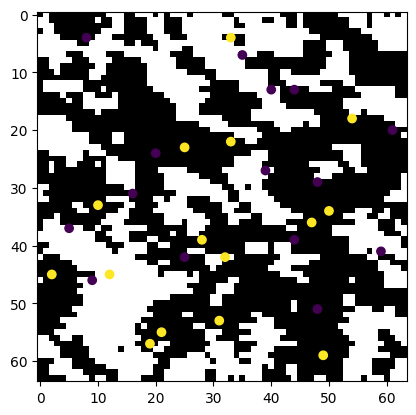

In [8]:
condition_indices = np.array([876,3825,2122,2892,1556,2683,3667,1767,483,2351,
                                2000,3312,2953,289,2373,2720,872,2713,1206,1341,
                                3541,2226,3423,1904,2882,2540,1497,2524,264,1441])
condition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,
                              1,1,1,0,1,0,1,1,0,1])
condition_indices_x = condition_indices // 64
condition_indices_y = condition_indices % 64
print(condition_indices_x)
print(condition_indices_y)
plt.imshow(training_data[0],cmap='gray')
plt.scatter(condition_indices_y,condition_indices_x,c=condition_values,cmap='viridis')
plt.show()

In [9]:
# Try training for, say, 500 epochs; you can also try mask_rate=1.0 for a stricter overfit test.
nr_epochs = 1000
batch_size = 100
mask_rate = 0.05  # Try also mask_rate = 1.0 to check if the network can memorize given only positional cues.
final_mask_rate = 0.95
mask_schedule = "exp"
patch_size = 2
num_heads = 2
num_layers = 2
ffn_dim = 256
emb_dim = 64
learning_rate = 1e-3
vocab_cap = 2000
"""
trained_model = run_training(training_data, nr_epochs, batch_size, mask_rate, final_mask_rate, mask_schedule, patch_size,
                             num_heads, num_layers, ffn_dim, learning_rate, emb_dim, vocab_cap)
"""


'\ntrained_model = run_training(training_data, nr_epochs, batch_size, mask_rate, final_mask_rate, mask_schedule, patch_size, \n                             num_heads, num_layers, ffn_dim, learning_rate, emb_dim, vocab_cap)\n'

In [9]:
# Load necessary libraries if not already loaded:
import torch
import numpy as np

# Assume training_data is already defined with shape (N, H, W)
N, H, W = training_data.shape

# Set parameters.
patch_size = 2
vocab_cap = 2000
vocab, counts, mask_token = build_vocabulary(training_data, patch_size, cap_size=vocab_cap)
patch_dim = patch_size ** 2
num_patches = (H // patch_size) ** 2
num_heads = 2
num_layers = 2
ffn_dim = 256
emb_dim = 64

# Create the model and load weights.
PATH = "model_epoch_1000.pth"
model = StackedContextViT(vocab, mask_token, patch_dim, num_patches,
                           emb_dim, num_heads, num_layers, ffn_dim)
# Note: if your torch.load expects "weights_only", adjust accordingly.
model.load_state_dict(torch.load(PATH, map_location='cpu'))  # remove weights_only if not applicable
model.eval()

# Generate 100 images using both methods for comparison.
manhattan_order = []
raster_order = []
random_order = []
# Optionally define some condition indices/values
# (You can modify these as needed; here we provide an example.)
condition_indices = np.array([876,3825,2122,2892,1556,2683,3667,1767,483,2351,
                              2000,3312,2953,289,2373,2720,872,2713,1206,1341,
                              3541,2226,3423,1904,2882,2540,1497,2524,264,1441])
condition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,
                              1,1,1,0,1,0,1,1,0,1])

for i in range(1000):
    gen_img_1, ll1 = generate_image(model, patch_size, W, condition_indices, condition_values,generation_order="manhattan")
    #gen_img_2, ll2 = generate_image(model, patch_size, W, condition_indices, condition_values,generation_order="raster")
    #gen_img_3, ll3 = generate_image(model, patch_size, W, condition_indices, condition_values,generation_order="random")
    manhattan_order.append(gen_img_1)
    #raster_order.append(gen_img_2)
    #random_order.append(gen_img_3)
    print(f"Image {i+1} generated: manhattan order LL={ll1:.4f}")

# Optionally: Save or visualize the generated images.
# For example, using matplotlib to display the first 3 images from both methods.
import matplotlib.pyplot as plt
for i in range(3):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(manhattan_order[i].cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
    axes[0].set_title(f"Manhattan Order {i+1}")
    axes[0].axis("off")





FileNotFoundError: [Errno 2] No such file or directory: 'model_epoch_1000.pth'

In [13]:
manhattan_order = torch.stack(manhattan_order)
raster_order = torch.stack(raster_order)
random_order = torch.stack(random_order)
manhattan_order = manhattan_order.cpu().detach().numpy()
raster_order = raster_order.cpu().detach().numpy()
random_order = random_order.cpu().detach().numpy()

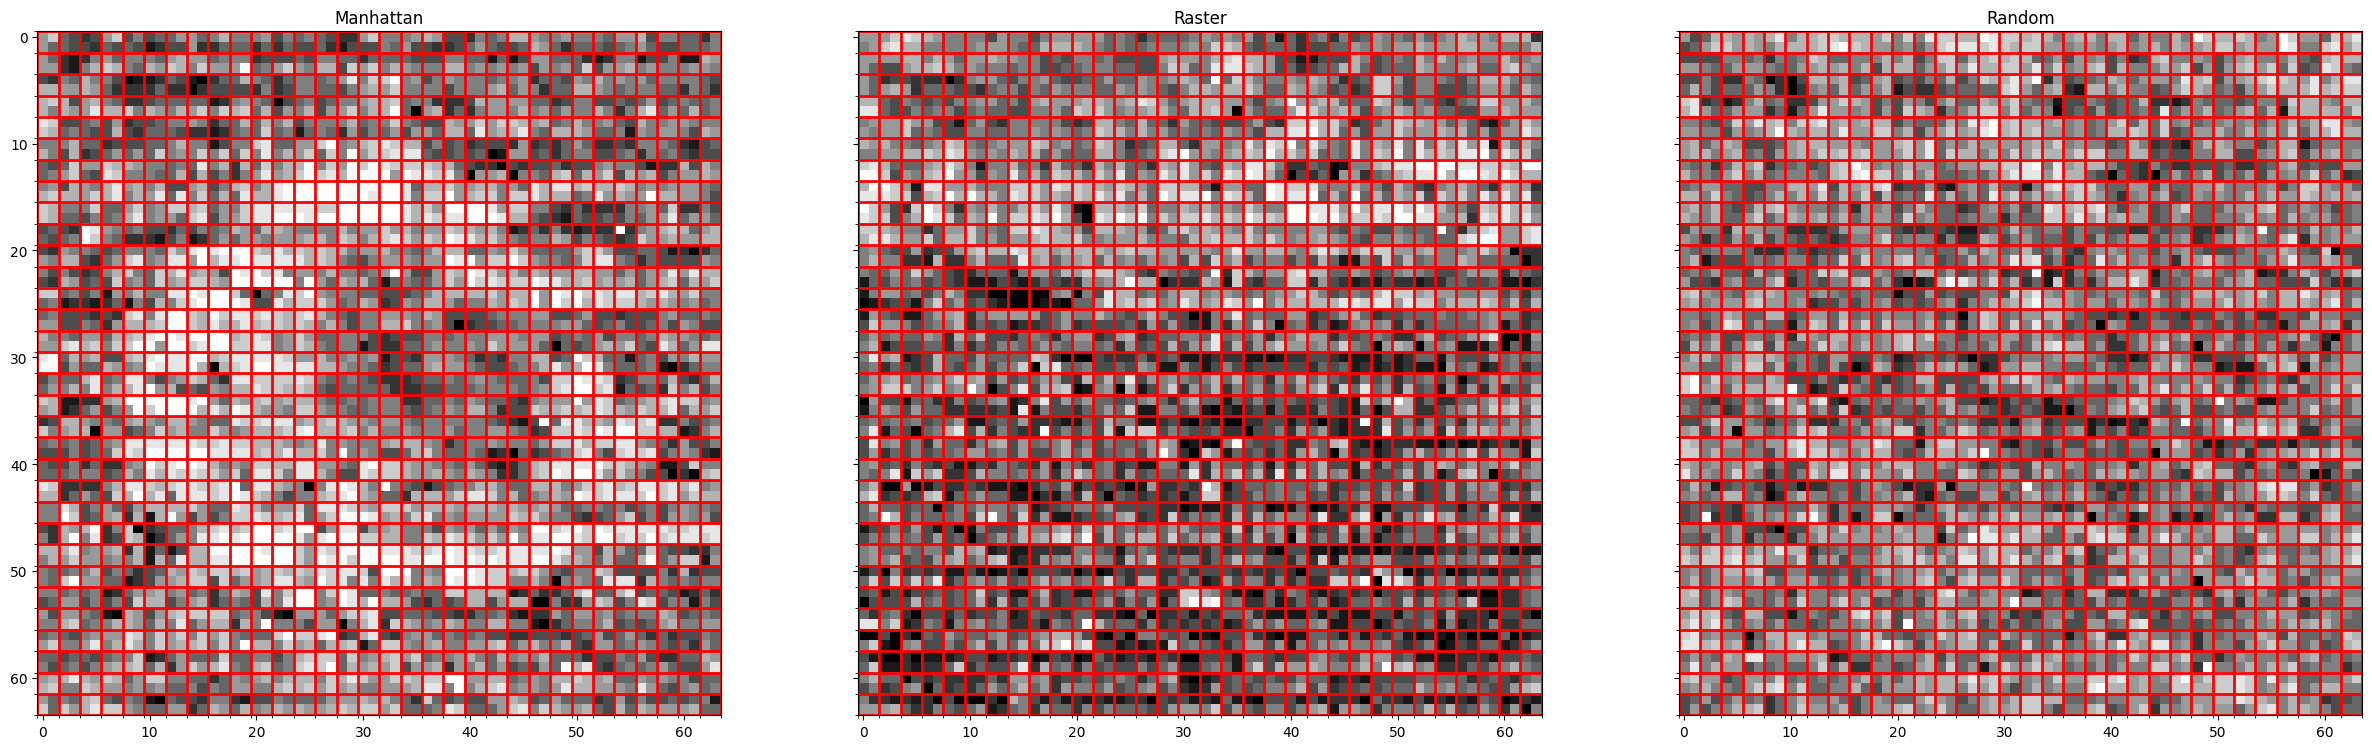

In [14]:
# Compute the marginal probabilities for each cell in the 1000 realizations
manhattan_marginal_probabilities = np.zeros((64,64))
raster_marginal_probabilities = np.zeros((64,64))
random_marginal_probabilities = np.zeros((64,64))
for i in range(64):
    for j in range(64):
        manhattan_marginal_probabilities[i,j] = np.mean(manhattan_order[:,i,j])
        raster_marginal_probabilities[i,j] = np.mean(raster_order[:,i,j])
        random_marginal_probabilities[i,j] = np.mean(random_order[:,i,j])

# Plot the marginal probabilities
fig, axs = plt.subplots(1,3, figsize=(30,10))

axs[0].imshow(manhattan_marginal_probabilities, cmap='gray')
# Add gridlines every 4 pixels, there should be 17 lines in each direction
axs[0].set_xticks(np.arange(-.5, 64, 2), minor=True)
axs[0].set_yticks(np.arange(-.5, 64, 2), minor=True)
axs[0].grid(which='minor', color='r', linestyle='-', linewidth=2)
axs[0].set_title('Manhattan')
axs[1].imshow(raster_marginal_probabilities, cmap='gray')
axs[1].set_xticks(np.arange(-.5, 64, 2), minor=True)
axs[1].set_yticks(np.arange(-.5, 64, 2), minor=True)
axs[1].grid(which='minor', color='r', linestyle='-', linewidth=2)
axs[1].set_title('Raster')
axs[2].imshow(random_marginal_probabilities, cmap='gray')
axs[2].set_xticks(np.arange(-.5, 64, 2), minor=True)
axs[2].set_yticks(np.arange(-.5, 64, 2), minor=True)
axs[2].grid(which='minor', color='r', linestyle='-', linewidth=2)
axs[2].set_title('Random')
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [39]:
import io
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
import imageio

def add_colored_border(token, border_width=1, border_color=(1, 0, 0)):
    """
    Convert a 2D token image (grayscale, values in [0,1]) to a 3-channel RGB image,
    and add a border of specified width and color.

    Args:
        token: numpy 2D array of shape (patch_size, patch_size).
        border_width: width (in pixels) of the border.
        border_color: tuple (R, G, B) with values in [0, 1] for the border color.

    Returns:
        token_with_border: numpy array of shape (patch_size+2*border_width, patch_size+2*border_width, 3).
    """
    # Convert token to RGB by stacking along the last dimension.
    token_rgb = np.stack([token] * 3, axis=-1)
    H, W, _ = token_rgb.shape
    new_H, new_W = H + 2 * border_width, W + 2 * border_width
    # Initialize a new image with a gray background (0.5).
    bordered = np.ones((new_H, new_W, 3)) * 0.5
    # Place the token in the center.
    bordered[border_width:border_width + H, border_width:border_width + W, :] = token_rgb
    # Set borders to the given border color.
    bordered[:border_width, :, :] = border_color
    bordered[-border_width:, :, :] = border_color
    bordered[:, :border_width, :] = border_color
    bordered[:, -border_width:, :] = border_color
    return bordered

def fig_to_np(fig):
    """Convert a Matplotlib figure to a NumPy array in RGB."""
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    img = Image.open(buf).convert("RGB")
    return np.array(img)

def generate_video(model, patch_size, image_size, condition_indices=None, condition_values=None,
                   topk=10, log_frequency=20, video_filename="generation.mp4", fps=4):
    """
    Generate an image conditionally while producing composite frames that are later combined into an MP4 video.

    For each logged generation step (every log_frequency updates), a composite figure with 4 subplots is created:
      1. Current image: unsampled patches appear as uniform gray (0.5). Observed condition points are overlaid
         with small scatter markers (blue for 0, red for 1), and the patch to be updated is highlighted by a green rectangle.
      2. A bar plot (with fixed axis limits) of the normalized token probabilities (if the patch has conditions, the filtered distribution is used).
      3. The top-k candidate tokens displayed as small images (side by side), in the same order as the bar plot.
      4. The deterministic reconstruction of the full image (obtained by taking argmax over logits for every patch).

    At the end, all composite frames are saved into a video file.

    Args:
        model: The trained ViT model. Assumes model.vocab is of shape [vocab_size, patch_dim] and model.mask_token is [patch_dim].
        patch_size: Side length (in pixels) of each patch (e.g., 2).
        image_size: Side length (in pixels) of the full image.
        condition_indices: (Optional) List/array of flattened indices for observed cells.
        condition_values: (Optional) Corresponding observed cell values (0 or 1).
        topk: Number of top candidates to display in the token bar plot and token images.
        log_frequency: Log a composite frame every this many patch updates.
        video_filename: Output video filename.
        fps: Frames per second for the output video.

    Returns:
        final_generated_image: The final generated image tensor.
        log_likelihood_sum: The total accumulated log-probability.
    """
    device = next(model.parameters()).device
    model.eval()

    grid_size = image_size // patch_size  # assume divisible
    total_patches = grid_size * grid_size
    patch_dim = patch_size * patch_size

    # Initialize generated patches with the model's mask token.
    generated_patches = model.mask_token.expand(total_patches, patch_dim).clone().to(device)
    # We keep a boolean flag for whether a patch has been sampled.
    sampled_flags = torch.zeros(total_patches, dtype=torch.bool, device=device)

    # Build mapping from patch index to list of (local_index, observed_value).
    conditions_by_patch = {}
    if (condition_indices is not None) and (condition_values is not None):
        for cond_idx, cond_val in zip(condition_indices, condition_values):
            pixel_row = cond_idx // image_size
            pixel_col = cond_idx % image_size
            patch_row = pixel_row // patch_size
            patch_col = pixel_col // patch_size
            patch_idx = patch_row * grid_size + patch_col
            local_idx = (pixel_row % patch_size) * patch_size + (pixel_col % patch_size)
            conditions_by_patch.setdefault(patch_idx, []).append((local_idx, cond_val))

    # Determine sampling order: observed patches first, then unobserved sorted by Manhattan distance.
    observed_patch_ids = sorted(list(conditions_by_patch.keys()))
    all_patch_indices = set(range(total_patches))
    for pid in observed_patch_ids:
        all_patch_indices.discard(pid)
    distance_list = []
    for p in all_patch_indices:
        row = p // grid_size
        col = p % grid_size
        dist_sum = sum(abs(row - (op // grid_size)) + abs(col - (op % grid_size)) for op in observed_patch_ids)
        distance_list.append((p, dist_sum))
    distance_list.sort(key=lambda x: x[1])
    unobserved_patch_ids = [p for p, _ in distance_list]
    sampling_order = observed_patch_ids + unobserved_patch_ids

    log_likelihood_sum = 0.0
    frames_list = []  # To collect composite frames for the video

    # Define a two-color colormap for condition scatter: blue=0, red=1.
    condition_cmap = ListedColormap(["blue", "red"])

    # Generation loop (using tqdm progress bar)
    for idx, patch_idx in enumerate(tqdm(sampling_order, desc="Sampling patches")):
        current_tokens = generated_patches.unsqueeze(0).clone()  # [1, total_patches, patch_dim]
        with torch.no_grad():
            logits_full, _ = model(current_tokens, mask_rate=0.0)  # [1, total_patches, vocab_size]
        logits_current = logits_full[0, patch_idx]  # [vocab_size]

        # Compute normalized probabilities (if patch has conditions, use filtered).
        probs_unfiltered = F.softmax(logits_current, dim=-1)
        if patch_idx in conditions_by_patch:
            valid_mask = torch.ones(model.vocab.shape[0], dtype=torch.bool, device=device)
            for local_idx, cond_val in conditions_by_patch[patch_idx]:
                valid_mask &= (model.vocab[:, local_idx] == cond_val)
            logits_filtered = logits_current.clone()
            logits_filtered[~valid_mask] = -float("inf")
            probs_norm = F.softmax(logits_filtered, dim=-1)
        else:
            probs_norm = probs_unfiltered.clone()

        # ---- Create Composite Figure for this step ----
        fig, axes = plt.subplots(1, 4, figsize=(28, 7))

        # (1) Current Image: Build a display image with unsampled patches forced to 0.5.
        display_patches = []
        for i in range(total_patches):
            if sampled_flags[i]:
                display_patches.append(generated_patches[i])
            else:
                display_patches.append(torch.full((patch_dim,), 0.5, device=device))
        display_tensor = torch.stack(display_patches)
        current_img = patches_to_image(display_tensor, (image_size, image_size), patch_size)
        axes[0].imshow(current_img.cpu().detach().numpy(), cmap="gray", vmin=0, vmax=1)
        # Overlay a scatter plot for conditions.
        if condition_indices is not None and condition_values is not None:
            cond_x = condition_indices // image_size
            cond_y = condition_indices % image_size
            axes[0].scatter(cond_y, cond_x, c=condition_values, cmap=condition_cmap, s=20, edgecolors="white")
        # Draw a green rectangle around the patch being updated.
        row_coord = (patch_idx // grid_size) * patch_size
        col_coord = (patch_idx % grid_size) * patch_size
        axes[0].add_patch(mpatches.Rectangle((col_coord - 0.5, row_coord - 0.5), patch_size, patch_size,
                                             linewidth=2, edgecolor="green", facecolor="none"))
        axes[0].set_title(f"Current Image (Patch {patch_idx} highlighted)")
        axes[0].axis("off")

        # (2) Bar Plot of Normalized Probabilities.
        top_vals, top_inds = torch.topk(probs_norm, k=topk)
        axes[1].bar(range(topk), top_vals.cpu().numpy(), color="purple")
        axes[1].set_xticks(range(topk))
        axes[1].set_xticklabels(top_inds.cpu().numpy())
        axes[1].set_ylabel("Probability")
        axes[1].set_title(f"Normalized Probabilities (Patch {patch_idx})")
        axes[1].set_ylim([0, 1])

        # (3) Token Patches: Display the top-k tokens as small images (side-by-side).
        token_imgs = []
        for idx in top_inds:
            token = model.vocab[idx].detach().cpu().reshape(patch_size, patch_size).numpy()
            # Add a colored border (here red) with a 1-pixel border:
            token_with_border = add_colored_border(token, border_width=1, border_color=(1, 0, 0))
            token_imgs.append(token_with_border)
        # Concatenate the bordered token images horizontally.
        token_grid = np.hstack(token_imgs)
        axes[2].imshow(token_grid, cmap="gray", vmin=0, vmax=1)
        axes[2].set_title("Top-k Token Candidates (with red border)")
        axes[2].axis("off")

        # (4) Deterministic Reconstruction: argmax across all patches.
        recon_tokens = torch.argmax(logits_full, dim=-1)[0]
        recon_patches = model.vocab[recon_tokens]
        recon_img = patches_to_image(recon_patches, (image_size, image_size), patch_size)
        axes[3].imshow(recon_img.cpu().detach().numpy(), cmap="gray", vmin=0, vmax=1)
        axes[3].set_title("Deterministic Reconstruction")
        axes[3].axis("off")

        plt.suptitle(f"Generation Step {idx}, Updating Patch {patch_idx}")
        composite_frame = fig_to_np(fig)
        plt.close(fig)

        # ----- End Composite Figure Creation -----

        # Append this composite frame if we are logging at this interval.
        if idx % log_frequency == 0:
            frames_list.append(composite_frame)

        # ----- Sampling Step -----
        final_probs = probs_norm  # use normalized probabilities (filtered if applicable)
        sampled_idx = torch.multinomial(final_probs, num_samples=1).item()
        lp = torch.log(final_probs[sampled_idx] + 1e-10).item()
        log_likelihood_sum += lp
        generated_patches[patch_idx] = model.vocab[sampled_idx]
        sampled_flags[patch_idx] = True

    # After finishing generation, construct the final image (unsampled -> 0.5).
    final_display = []
    for i in range(total_patches):
        if sampled_flags[i]:
            final_display.append(generated_patches[i])
        else:
            final_display.append(torch.full((patch_dim,), 0.5, device=device))
    final_tensor = torch.stack(final_display)
    final_generated_image = patches_to_image(final_tensor, (image_size, image_size), patch_size)

    # Save video using imageio.
    import imageio
    imageio.mimwrite(video_filename, frames_list, fps=fps)
    print(f"Video saved as {video_filename}")

    return final_generated_image, log_likelihood_sum

In [40]:
final_img, total_logp = generate_video(model, patch_size, W,
                                                     condition_indices,
                                                     condition_values,
                                                     topk=16, log_frequency=1,video_filename="conditional_generation.mp4",fps=4)

Sampling patches: 100%|██████████| 1024/1024 [07:30<00:00,  2.27it/s]


Video saved as conditional_generation.mp4


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import wandb
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

########################################
# Helper: Convert Patches to Integer Code
########################################

def patch_to_int(patches):
    """
    Converts a tensor of patches (shape: [N, patch_dim]) containing binary values
    to an integer code. Assumes values are near 0 or 1.
    """
    patches_bin = patches.round().long()  # ensure binary
    patch_dim = patches_bin.shape[1]
    powers = (2 ** torch.arange(patch_dim - 1, -1, -1, device=patches.device)).unsqueeze(0)
    codes = (patches_bin * powers).sum(dim=1)
    return codes

########################################
# Helper: Image Sampling (Conditional)
########################################

def sample_image_conditional(model, patch_size, image_size, temperature=1.0,
                             condition_indices=None, condition_values=None):
    """
    Generate one image using the autoregressive model while enforcing conditions.
    Instead of a fixed raster-scan order, this function first generates the patches
    that contain condition values and then fills in the rest in order of increasing
    Manhattan distance from any conditioned patch.

    Returns:
      - generated: a tensor of shape (1, num_patches, patch_dim)
      - log_likelihood: the sum of log-probabilities for the sampled tokens.
    """
    num_patches = (image_size // patch_size) ** 2
    patch_dim = patch_size * patch_size
    grid_size = image_size // patch_size

    # Build patch-level conditions: a dictionary mapping patch index -> {local index: condition value}
    patch_conditions = {}
    if condition_indices is not None and condition_values is not None:
        for cond_idx, cond_val in zip(condition_indices, condition_values):
            global_row = int(cond_idx) // image_size
            global_col = int(cond_idx) % image_size
            patch_row = global_row // patch_size
            patch_col = global_col // patch_size
            patch_index = patch_row * grid_size + patch_col
            local_row = global_row % patch_size
            local_col = global_col % patch_size
            local_index = local_row * patch_size + local_col
            if patch_index not in patch_conditions:
                patch_conditions[patch_index] = {}
            patch_conditions[patch_index][local_index] = float(cond_val)

    # Define a helper to compute patch coordinates.
    def patch_coords(i):
        return (i // grid_size, i % grid_size)

    # Determine generation order.
    # First, the conditioned patch indices (those that appear in patch_conditions).
    conditioned_indices = set(patch_conditions.keys())
    conditioned_list = sorted(list(conditioned_indices))

    # Then, the remaining indices sorted by minimum Manhattan distance to any conditioned patch.
    remaining = [i for i in range(num_patches) if i not in conditioned_indices]
    def min_distance(i):
        r_i, c_i = patch_coords(i)
        # If no conditioned patch, return a high number.
        return min(abs(r_i - patch_coords(j)[0]) + abs(c_i - patch_coords(j)[1])
                   for j in conditioned_indices) if conditioned_indices else 0
    remaining = sorted(remaining, key=min_distance)

    # Final generation order: first fill in conditioned patches, then the rest.
    order_list = conditioned_list + remaining

    # Initialize generated patches with the learnable mask token.
    generated = model.mask_token.detach().clone().unsqueeze(0).repeat(num_patches, 1)
    log_likelihood = 0.0
    # Add a batch dimension.
    generated = generated.unsqueeze(0)  # shape: (1, num_patches, patch_dim)

    # Generate patches in the determined order.
    for idx in order_list:
        # Optionally, if this patch has a condition, restrict candidates.
        cond = patch_conditions.get(idx, None)
        # Compute logits for the entire sequence.
        logits = model(generated)  # shape: (1, num_patches, vocab_size)
        logits_i = logits[0, idx] / temperature
        if cond is not None:
            candidate_mask = torch.ones(model.vocab_size, dtype=torch.bool, device=logits_i.device)
            for local_idx, cond_val in cond.items():
                candidate_mask = candidate_mask & (model.vocab[:, local_idx] == cond_val)
            logits_i = logits_i.masked_fill(~candidate_mask, -1e9)
        probs = torch.softmax(logits_i, dim=-1)
        token = torch.multinomial(probs, num_samples=1)
        log_prob = torch.log(probs[token] + 1e-10)
        log_likelihood += log_prob.item()
        patch = model.vocab[token]
        generated[0, idx] = patch

    return generated, log_likelihood

########################################
# Vision Transformer and Transformer Encoder Layer
########################################

class VisionTransformer(nn.Module):
    def __init__(self, num_heads, num_layers, ffn_dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_dim, num_heads, ffn_dim, dropout)
            for _ in range(num_layers)
        ])
        self.dropout_layer = nn.Dropout(dropout)

    def build_vocabulary(self, training_data, patch_size, full_mask=True, one_mask=True):
        self.patch_size = patch_size
        patch_dim = patch_size * patch_size
        H, W = training_data.shape[1], training_data.shape[2]
        num_patches = (H // patch_size) * (W // patch_size)
        patches_tensor = training_data.unfold(1, patch_size, patch_size)\
                                        .unfold(2, patch_size, patch_size)
        patches_tensor = patches_tensor.contiguous().view(-1, patch_dim)
        unique_set = set()
        unique_list = []
        for patch in tqdm(patches_tensor, desc=f"Building Vocabulary for {patch_size}x{patch_size}", total=patches_tensor.shape[0]):
            patch_cpu = patch.cpu()
            patch_tuple = tuple(patch_cpu.tolist())
            if patch_tuple not in unique_set:
                unique_set.add(patch_tuple)
                unique_list.append(patch_cpu)
        if full_mask:
            unique_list.append(torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu'))
        if one_mask:
            for i in range(patch_dim):
                mask_patch = torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu')
                mask_patch[i] = 0.0
                unique_list.append(mask_patch)
                mask_patch = torch.full((patch_dim,), 0.5, dtype=torch.float, device='cpu')
                mask_patch[i] = 1.0
                unique_list.append(mask_patch)
        self.vocab = torch.stack(unique_list)
        self.vocab_size = self.vocab.size(0)
        self.vocab_int = patch_to_int(self.vocab)
        self.embedding_projection = nn.Linear(patch_dim, self.hidden_dim)
        self.output_projection = nn.Linear(self.hidden_dim, self.vocab_size)
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches, self.hidden_dim))
        self.mask_token = nn.Parameter(torch.full((patch_dim,), 0.5, dtype=torch.float))
        return self.vocab

    def forward(self, patches):
        # patches: (B, num_patches, patch_dim)
        B, num_patches, _ = patches.shape
        embeddings = self.embedding_projection(patches)
        embeddings = embeddings + self.pos_embedding[:, :num_patches, :]
        z = self.dropout_layer(embeddings)
        for layer in self.transformer_layers:
            z = layer(z)
        logits = self.output_projection(z)  # (B, num_patches, vocab_size)
        return logits

class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, ffn_dim, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout)
        self.linear1 = nn.Linear(hidden_dim, ffn_dim)
        self.linear2 = nn.Linear(ffn_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, z):
        z_norm = self.norm1(z)
        z_t = z_norm.transpose(0, 1)
        attn_output, _ = self.self_attn(z_t, z_t, z_t)
        attn_output = attn_output.transpose(0, 1)
        z = z + self.dropout1(attn_output)
        z_norm = self.norm2(z)
        ff_output = self.linear2(self.dropout2(self.activation(self.linear1(z_norm))))
        z = z + self.dropout2(ff_output)
        return z

########################################
# Dataset and Patch Extraction
########################################

class BinaryImageDataset(Dataset):
    def __init__(self, images):
        self.images = images  # shape: (N, H, W)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        return self.images[idx]
    @staticmethod
    def batch_to_patches(images, patch_size):
        B, H, W = images.shape
        patches = images.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
        patches = patches.contiguous().view(B, -1, patch_size * patch_size)
        return patches
    @staticmethod
    def patches_to_image(patches, patch_size, image_size):
        # patches: (num_patches, patch_dim) ordered in raster scan.
        image = torch.zeros(image_size, image_size, device=patches.device)
        idx = 0
        for i in range(0, image_size, patch_size):
            for j in range(0, image_size, patch_size):
                image[i:i+patch_size, j:j+patch_size] = patches[idx].view(patch_size, patch_size)
                idx += 1
        return image

########################################
# Training Pipeline (Loss only on masked tokens)
########################################

def train_model_for_patch(patch_size, training_data, start_epoch=0, total_epochs=1000, batch_size=128, checkpoint_path=None):
    # Increased model capacity.
    num_heads = 8
    num_layers = 8
    ffn_dim = 1024
    hidden_dim = 256

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    training_data = training_data.to(device)
    image_size = training_data.shape[1]

    # Initialize wandb with updated total_epochs and a name reflecting the resumed run.
    wandb.init(project="vision-transformer-comparison",
               config={
                   "num_heads": num_heads,
                   "num_layers": num_layers,
                   "ffn_dim": ffn_dim,
                   "hidden_dim": hidden_dim,
                   "patch_size": patch_size,
                   "start_epoch": start_epoch,
                   "total_epochs": total_epochs,
                   "batch_size": batch_size
               },
               name=f"patch_{patch_size}x{patch_size}_epochs{start_epoch+1}-{total_epochs}",
               reinit=True)

    model = VisionTransformer(num_heads, num_layers, ffn_dim, hidden_dim, dropout=0.1)
    model.build_vocabulary(training_data, patch_size)
    model = model.to(device)
    model.vocab = model.vocab.to(device)
    model.vocab_int = patch_to_int(model.vocab).to(device)

    # --- RESUME: Load checkpoint if provided ---
    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint)
        print(f"Loaded checkpoint from {checkpoint_path}")

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    dataset = BinaryImageDataset(training_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # --- Training loop from start_epoch to total_epochs ---
    for epoch in range(start_epoch, total_epochs):
        model.train()
        total_loss = 0.0

        # Gradual mask schedule based on the global epoch number.
        num_patches = (image_size // patch_size) ** 2
        min_mask_rate = 1.0 / num_patches
        # The mask rate increases gradually from a single masked patch (min_mask_rate)
        # to a fully masked image (1.0) over total_epochs.
        base_mask_rate = min_mask_rate + (1.0 - min_mask_rate) * (epoch / total_epochs)
        mask_rate = np.clip(base_mask_rate + np.random.uniform(-0.1, 0.1), min_mask_rate, 1.0)
        partial_mask_rate = 0.3  # Keep the partially masked rate constant.

        epoch_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{total_epochs} (patch {patch_size}x{patch_size})", leave=False)
        for batch in epoch_bar:
            batch = batch.to(device)
            B = batch.shape[0]
            patches = BinaryImageDataset.batch_to_patches(batch, patch_size)  # (B, num_patches, patch_dim)
            patch_dim = patches.shape[2]

            # Create mask for each patch (only masked tokens contribute to loss).
            mask = torch.rand(B, num_patches, device=device) < mask_rate
            mask[:, 0] = True

            partial = (torch.rand(B, num_patches, device=device) < partial_mask_rate) & mask
            full = mask & (~partial)

            masked_patches = patches.clone()
            if full.any():
                masked_patches[full] = model.mask_token
            if partial.any():
                partial_idx = torch.nonzero(partial)
                num_partial = partial_idx.shape[0]
                new_patches = torch.full((num_partial, patch_dim), 0.5, device=device)
                rand_positions = torch.randint(0, patch_dim, (num_partial,), device=device)
                orig_vals = patches[partial_idx[:, 0], partial_idx[:, 1], :].gather(1, rand_positions.unsqueeze(1)).squeeze(1)
                new_patches[torch.arange(num_partial), rand_positions] = orig_vals
                masked_patches[partial_idx[:, 0], partial_idx[:, 1]] = new_patches

            # Forward pass.
            logits = model(masked_patches)  # (B, num_patches, vocab_size)

            # Compute targets over all patches.
            all_patches = patches.view(B * num_patches, patch_dim)
            codes = patch_to_int(all_patches)
            vocab_codes = model.vocab_int
            mask_eq = codes.unsqueeze(1) == vocab_codes.unsqueeze(0)
            target_indices = mask_eq.float().argmax(dim=1)
            targets_all = target_indices.view(B, num_patches)

            # Compute loss only over masked tokens.
            if mask.sum() > 0:
                loss = criterion(logits[mask], targets_all[mask])
            else:
                loss = torch.tensor(0.0, device=device)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            epoch_bar.set_postfix(loss=loss.item(), mask_rate=mask_rate)
        avg_loss = total_loss / len(dataloader)
        wandb.log({"epoch": epoch, "loss": avg_loss, "mask_rate": mask_rate})
        print(f"[Patch {patch_size}x{patch_size}] Epoch {epoch+1}/{total_epochs}, Loss: {avg_loss:.4f}, Mask Rate: {mask_rate:.2f}")

        # --- Visualization on First Batch (unchanged) ---
        model.eval()
        with torch.no_grad():
            batch0 = next(iter(dataloader)).to(device)
            patches0 = BinaryImageDataset.batch_to_patches(batch0, patch_size)
            B0, num_patches, patch_dim = patches0.shape
            vis_mask = (torch.rand(1, num_patches, device=device) < mask_rate).squeeze(0)
            vis_mask[0] = True
            vis_partial = (torch.rand(1, num_patches, device=device) < partial_mask_rate).squeeze(0) & vis_mask
            vis_full = vis_mask & (~vis_partial)
            masked_vis = patches0[0].clone()
            if vis_full.any():
                masked_vis[vis_full] = model.mask_token
            if vis_partial.any():
                partial_idx_vis = torch.nonzero(vis_partial)
                num_partial_vis = partial_idx_vis.shape[0]
                new_patches_vis = torch.full((num_partial_vis, patch_dim), 0.5, device=device)
                rand_positions_vis = torch.randint(0, patch_dim, (num_partial_vis,), device=device)
                orig_vals_vis = patches0[0, partial_idx_vis[:, 0], :].gather(1, rand_positions_vis.unsqueeze(1)).squeeze(1)
                new_patches_vis[torch.arange(num_partial_vis), rand_positions_vis] = orig_vals_vis
                masked_vis[partial_idx_vis[:, 0]] = new_patches_vis
            logits_vis = model(masked_vis.unsqueeze(0))
            predicted_tokens = torch.argmax(logits_vis, dim=-1).squeeze(0)
            recon_vis = patches0[0].clone()
            recon_vis[vis_mask] = model.vocab[predicted_tokens[vis_mask]]
            masked_img = BinaryImageDataset.patches_to_image(masked_vis, patch_size, image_size)
            recon_img = BinaryImageDataset.patches_to_image(recon_vis, patch_size, image_size)
            original_img = BinaryImageDataset.patches_to_image(patches0[0], patch_size, image_size)
            wandb.log({
                "original": wandb.Image(original_img.cpu()),
                "masked": wandb.Image(masked_img.cpu()),
                "reconstructed": wandb.Image(recon_img.cpu())
            })

        # --- Every 100 Epochs: Conditional Sampling and Saving Checkpoints ---
        if (epoch + 1) % 100 == 0:
            condition_indices = np.array([876,3825,2122,2892,1556,2683,3667,1767,483,2351,2000,3312,
                                          2953,289,2373,2720,872,2713,1206,1341,3541,2226,3423,1904,
                                          2882,2540,1497,2524,264,1441])
            condition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,1,0,1,0,1,1,0,1])
            gen, ll = sample_image_conditional(model, patch_size, image_size, temperature=1.0,
                                               condition_indices=condition_indices,
                                               condition_values=condition_values)
            gen_img = BinaryImageDataset.patches_to_image(gen[0], patch_size, image_size)
            wandb.log({"conditional_sample": wandb.Image(gen_img.cpu(), caption=f"LL: {ll:.2f}")})

        if (epoch + 1) % 100 == 0:
            torch.save(model.state_dict(), f"vision_transformer_patch{patch_size}x{patch_size}_epoch{epoch+1}.pth")
    wandb.finish()
    return model

# --- Example of resuming training ---
"""
if __name__ == "__main__":
    arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
    training_data = arr[:9000]
    training_data = training_data.reshape(-1, 64, 64)
    print("Training data shape:", training_data.shape)
    training_data = torch.tensor(training_data, dtype=torch.float32)
    patch_size = 4

    # Resume training from epoch 800 for an additional 500 epochs (total_epochs = 1300).
    model = train_model_for_patch(patch_size, training_data, start_epoch=800, total_epochs=1300,
                                  checkpoint_path="vision_transformer_patch4x4_epoch800 (1).pth")
"""

'\nif __name__ == "__main__":\n    arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]\n    training_data = arr[:9000]\n    training_data = training_data.reshape(-1, 64, 64)\n    print("Training data shape:", training_data.shape)\n    training_data = torch.tensor(training_data, dtype=torch.float32)\n    patch_size = 4\n\n    # Resume training from epoch 800 for an additional 500 epochs (total_epochs = 1300).\n    model = train_model_for_patch(patch_size, training_data, start_epoch=800, total_epochs=1300,\n                                  checkpoint_path="vision_transformer_patch4x4_epoch800 (1).pth")\n'

In [7]:
# Parameters.
patch_size = 4
image_size = 64  # note: training images are 64x64 now (adjust if needed)

# Provided condition indices and values (global pixel indices over a flattened 64x64 image)
condition_indices = np.array([876,3825,2122,2892,1556,2683,3667,1767,483,2351,
                                2000,3312,2953,289,2373,2720,872,2713,1206,1341,
                                3541,2226,3423,1904,2882,2540,1497,2524,264,1441])
condition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,
                               1,1,1,0,1,0,1,1,0,1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build the model architecture with the same hyperparameters as training.
num_heads = 8
num_layers = 8
ffn_dim = 1024
hidden_dim = 256
dropout = 0.1

model = VisionTransformer(num_heads, num_layers, ffn_dim, hidden_dim, dropout)

arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
training_data = arr[:9000]
training_data = training_data.reshape(-1, 64, 64)  # 60x60 images; adjust if needed.
print("Training data shape:", training_data.shape)
training_data = torch.tensor(training_data, dtype=torch.float32)
# Load the saved vocabulary so that the output projection has the correct dimensions.
vocab = model.build_vocabulary(training_data,patch_size)
model.vocab = vocab.to(device)
model.vocab_int = patch_to_int(model.vocab).to(device)
# Rebuild the output projection to match the vocab size.
model.output_projection = nn.Linear(model.hidden_dim, model.vocab.size(0)).to(device)
model = model.to(device)
checkpoint_dir = ""
epoch = 1100
ckpt_path = os.path.join(checkpoint_dir, f"vision_transformer_patch{patch_size}x{patch_size}_epoch{epoch}.pth")
print(f"Loading checkpoint: {ckpt_path}")
state_dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

Training data shape: (9000, 64, 64)


Building Vocabulary for 4x4: 100%|██████████| 2304000/2304000 [00:10<00:00, 211129.36it/s]


Loading checkpoint: vision_transformer_patch4x4_epoch1100.pth


VisionTransformer(
  (transformer_layers): ModuleList(
    (0-7): 8 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (linear1): Linear(in_features=256, out_features=1024, bias=True)
      (linear2): Linear(in_features=1024, out_features=256, bias=True)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (activation): GELU(approximate='none')
    )
  )
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (embedding_projection): Linear(in_features=16, out_features=256, bias=True)
  (output_projection): Linear(in_features=256, out_features=30605, bias=True)
)